# Changing laplacians

In [1]:
import os
import sys
#import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt

from utils import set_device
from laplacian import normalized_laplacian

sys.path.insert(0, "lib/")
%load_ext autoreload
%autoreload 2

# MNIST

In [2]:
# Downloads the dataset if not found locally
from Dataset import check_mnist_dataset_exists, datasampler, MNISTDataset
_ = check_mnist_dataset_exists()

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data=640, nb_selected_test_data=512
)

testset = MNISTDataset(test_data, test_labels)

## Convolution layer and classifier


In [3]:
from model import Classifier, SanityCheck, SmallCheb

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels, signals = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels),  torch.stack(signals).view(-1)



# Model definition for training

In [4]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep'))

<All keys matched successfully>

# Test

In [6]:
import sklearn
from sklearn.metrics import classification_report


def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg)
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, L), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

    print('\n \n ', sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4))

## Original lattice

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


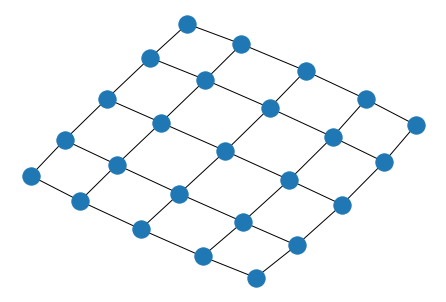

In [7]:
from graphs import regular_2D_lattice

g = regular_2D_lattice(5)
nx.draw(g.to_networkx().to_undirected())

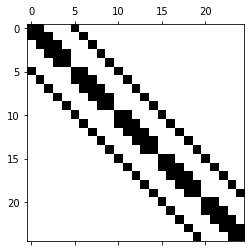

In [8]:
L = normalized_laplacian(g)
plt.spy(L.to_dense())

In [9]:
# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        42
           1     1.0000    1.0000    1.0000        69
           2     0.9636    0.9464    0.9550        56
           3     1.0000    0.9583    0.9787        48
           4     0.9636    0.9464    0.9550        56
           5     0.9800    0.9423    0.9608        52
           6     0.9762    0.9318    0.9535        44
           7     0.9608    0.9800    0.9703        50
           8     0.8864    0.9750    0.9286        40
           9     0.9630    0.9455    0.9541        55

    accuracy                         0.9629       512
   macro avg     0.9607    0.9626    0.9610       512
weighted avg     0.9641    0.9629    0.9630       512



## Other lattice

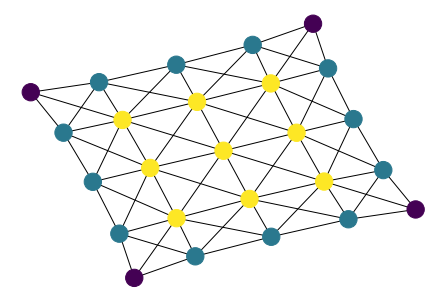

In [10]:
from graphs import regular_2D_lattice_8_neighbors

g2 = regular_2D_lattice_8_neighbors(5)
nx.draw(g2.to_networkx().to_undirected(),node_color=np.array(g2.to_networkx().to_undirected().degree())[:,1],cmap=plt.cm.viridis)

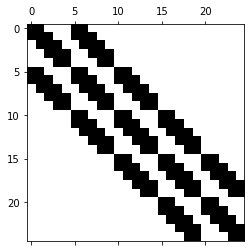

In [11]:
L2 = normalized_laplacian(g2)
plt.spy(L2.to_dense(),precision=0.1)

Norm 1 distance: tensor(28.2855) 
Norm 2 distance: tensor(2.5502)


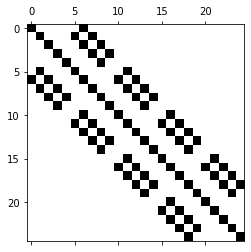

In [12]:
res = L2-L
print('Norm 1 distance:', torch.norm(res, p=1),
      '\nNorm 2 distance:', torch.norm(res, p=2))
plt.spy(res.to_dense(), precision=0.1)

In [13]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.8837    0.9048    0.8941        42
           1     1.0000    0.7971    0.8871        69
           2     0.9787    0.8214    0.8932        56
           3     0.7321    0.8542    0.7885        48
           4     0.8958    0.7679    0.8269        56
           5     0.8250    0.6346    0.7174        52
           6     0.9302    0.9091    0.9195        44
           7     0.9091    0.2000    0.3279        50
           8     0.5741    0.7750    0.6596        40
           9     0.4522    0.9455    0.6118        55

    accuracy                         0.7598       512
   macro avg     0.8181    0.7609    0.7526       512
weighted avg     0.8269    0.7598    0.7561       512



## Random supression

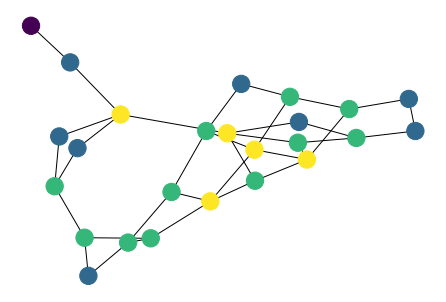

In [13]:
from graphs import random_edge_suppression

g3 = random_edge_suppression(5,5)
nx.draw(g3.to_networkx().to_undirected(),node_color=np.array(g3.to_networkx().to_undirected().degree())[:,1],cmap=plt.cm.viridis)

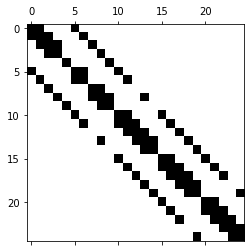

In [14]:
L3 = normalized_laplacian(g3)
plt.spy(L3.to_dense())

In [15]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.9318    0.9762    0.9535        42
           1     1.0000    1.0000    1.0000        69
           2     0.9643    0.9643    0.9643        56
           3     1.0000    0.9583    0.9787        48
           4     0.9643    0.9643    0.9643        56
           5     0.9800    0.9423    0.9608        52
           6     0.9773    0.9773    0.9773        44
           7     0.9423    0.9800    0.9608        50
           8     0.8864    0.9750    0.9286        40
           9     1.0000    0.9273    0.9623        55

    accuracy                         0.9668       512
   macro avg     0.9646    0.9665    0.9650       512
weighted avg     0.9681    0.9668    0.9670       512



Norm 1 distance: tensor(5.8588) 
Norm 2 distance: tensor(1.1431)


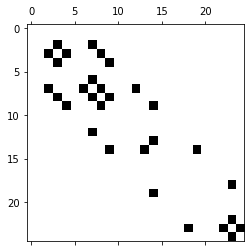

In [16]:
res = L3-L
print('Norm 1 distance:', torch.norm(res, p=1),
      '\nNorm 2 distance:', torch.norm(res, p=2))
plt.spy(res.to_dense(), precision=0.05)

# Model trained on the 8 lattice

In [17]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep_8_lattice'))

<All keys matched successfully>

## Original lattice

In [19]:
testset = MNISTDataset(test_data, test_labels, lattice_type=0)

# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667        42
           1     0.8961    1.0000    0.9452        69
           2     0.6623    0.9107    0.7669        56
           3     0.8636    0.3958    0.5429        48
           4     0.9655    0.5000    0.6588        56
           5     0.3770    0.8846    0.5287        52
           6     0.9130    0.4773    0.6269        44
           7     0.3643    0.9400    0.5251        50
           8     1.0000    0.1000    0.1818        40
           9     0.8000    0.0727    0.1333        55

    accuracy                         0.6074       512
   macro avg     0.7759    0.5805    0.5576       512
weighted avg     0.7714    0.6074    0.5763       512



## 8 lattice

In [20]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        42
           1     1.0000    1.0000    1.0000        69
           2     0.9818    0.9643    0.9730        56
           3     0.9787    0.9583    0.9684        48
           4     0.9474    0.9643    0.9558        56
           5     0.9423    0.9423    0.9423        52
           6     0.9762    0.9318    0.9535        44
           7     0.9412    0.9600    0.9505        50
           8     0.9512    0.9750    0.9630        40
           9     0.9615    0.9091    0.9346        55

    accuracy                         0.9609       512
   macro avg     0.9593    0.9605    0.9596       512
weighted avg     0.9615    0.9609    0.9609       512



## Random suppresion

In [21]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
test_func(data_loader_test)


 
                precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667        42
           1     0.8519    1.0000    0.9200        69
           2     0.6375    0.9107    0.7500        56
           3     0.8571    0.3750    0.5217        48
           4     0.9615    0.4464    0.6098        56
           5     0.4412    0.8654    0.5844        52
           6     0.9130    0.4773    0.6269        44
           7     0.3264    0.9400    0.4845        50
           8     1.0000    0.1000    0.1818        40
           9     0.8571    0.1091    0.1935        55

    accuracy                         0.6016       512
   macro avg     0.7762    0.5748    0.5539       512
weighted avg     0.7706    0.6016    0.5718       512

